# Previous Trial Effects on Decision Making

This notebook investigates whether **previous trial outcomes** influence current trial decisions.

**Hypothesis**: As participants play more trials, they learn the task is biased toward INVEST (~66%).
This could mean:
1. Previous trial outcome predicts current decision
2. Running investment rate influences current decision
3. Trial position (early vs late) affects decision patterns

**Analysis**:
1. Add sequential features (previous outcome, running rate, trial position)
2. Test if these features improve late fusion model accuracy
3. Analyze how predictive power changes across trial positions

In [64]:
# ============================================================================
# CONFIGURATION
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from src.utils.io import load_features, save_results
from src.utils.config import load_config
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*70}")
print(f"PREVIOUS TRIAL EFFECTS ANALYSIS: {TIMEFRAME}-DECISION")
print(f"{'='*70}\n")


PREVIOUS TRIAL EFFECTS ANALYSIS: PRE-DECISION



## 1. Load Data and Extract Trial Sequence

In [65]:
# Load pre-extracted features
features_path = f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df'].copy()
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nSample trial_id format: {merged_df['trial_id'].iloc[0]}")
print(f"Sample subject_id format: {merged_df['subject_id'].iloc[0]}")

Loaded 12511 trials from 97 subjects

Sample trial_id format: 4_0806_1000_539136F
Sample subject_id format: 0806_1000_539136F


In [66]:
# Extract trial number from trial_id
# Format: "{trial_number}_{subject_id}" e.g., "23_0806_1000_539136F"
# trial_number is the first part before the first underscore

def extract_trial_number(trial_id):
    """Extract the trial number from trial_id."""
    parts = trial_id.split('_')
    return int(parts[0])

merged_df['trial_number'] = merged_df['trial_id'].apply(extract_trial_number)

print(f"Trial number range: {merged_df['trial_number'].min()} to {merged_df['trial_number'].max()}")
print(f"\nTrials per subject:")
trials_per_subject = merged_df.groupby('subject_id')['trial_number'].agg(['min', 'max', 'count'])
print(trials_per_subject.describe())

Trial number range: 0 to 179

Trials per subject:
             min         max       count
count  97.000000   97.000000   97.000000
mean    1.948454  132.154639  128.979381
std     2.643274   20.179063   36.193916
min     0.000000    9.000000    9.000000
25%     0.000000  131.000000  121.000000
50%     1.000000  132.000000  128.000000
75%     3.000000  135.000000  131.000000
max    12.000000  179.000000  246.000000


In [67]:
# Sort trials within each subject by trial number
merged_df = merged_df.sort_values(['subject_id', 'trial_number']).reset_index(drop=True)

print("Data sorted by subject and trial number")
print(f"\nFirst 10 rows:")
print(merged_df[['subject_id', 'trial_number', 'outcome']].head(10))

Data sorted by subject and trial number

First 10 rows:
          subject_id  trial_number  outcome
0  0806_1000_539136F             4        1
1  0806_1000_539136F             5        1
2  0806_1000_539136F             8        1
3  0806_1000_539136F             9        0
4  0806_1000_539136F            12        1
5  0806_1000_539136F            13        0
6  0806_1000_539136F            14        1
7  0806_1000_539136F            17        0
8  0806_1000_539136F            18        0
9  0806_1000_539136F            19        1


## 2. Create Sequential Features

In [68]:
def add_sequential_features(df, group_col='subject_id'):
    """
    Add sequential/history features within each subject.
    
    Features added:
    - prev_outcome: Previous trial outcome (lag-1)
    - prev_outcome_2: Outcome from 2 trials ago (lag-2)
    - running_invest_rate: Cumulative investment rate up to (but not including) current trial
    - recent_invest_rate_5: Investment rate over last 5 trials
    - trial_position: Normalized position (0-1) within session
    - consecutive_same: Number of consecutive same decisions before current
    """
    # Previous outcomes (lag features)
    df['prev_outcome'] = df.groupby(group_col)['outcome'].shift(1)
    df['prev_outcome_2'] = df.groupby(group_col)['outcome'].shift(2)
    
    # Running investment rate (cumulative mean excluding current trial)
    df['running_invest_rate'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    
    # Recent investment rate (last 5 trials)
    df['recent_invest_rate_5'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
    )
    
    # Trial position within session (normalized 0-1)
    df['trial_position'] = df.groupby(group_col)['trial_number'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    
    # Count consecutive same decisions before current trial
    def count_consecutive(series):
        result = [0]
        count = 0
        for i in range(1, len(series)):
            if series.iloc[i-1] == series.iloc[i-2] if i > 1 else True:
                count += 1
            else:
                count = 0
            result.append(count)
        return pd.Series(result, index=series.index)
    
    df['consecutive_same'] = df.groupby(group_col)['outcome'].transform(count_consecutive)
    
    return df

# Add sequential features
merged_df = add_sequential_features(merged_df)

# Define sequential feature columns
sequential_cols = ['prev_outcome', 'prev_outcome_2', 'running_invest_rate', 
                   'recent_invest_rate_5', 'trial_position', 'consecutive_same']

print("Sequential features added:")
for col in sequential_cols:
    non_null = merged_df[col].notna().sum()
    print(f"  {col}: {non_null} non-null values ({100*non_null/len(merged_df):.1f}%)")

Sequential features added:
  prev_outcome: 12414 non-null values (99.2%)
  prev_outcome_2: 12317 non-null values (98.4%)
  running_invest_rate: 12414 non-null values (99.2%)
  recent_invest_rate_5: 12414 non-null values (99.2%)
  trial_position: 12511 non-null values (100.0%)
  consecutive_same: 12511 non-null values (100.0%)


In [69]:
# Show example of sequential features for one subject
example_subject = merged_df['subject_id'].iloc[0]
example_data = merged_df[merged_df['subject_id'] == example_subject].head(15)

print(f"\nExample: First 15 trials for subject {example_subject}")
print(example_data[['trial_number', 'outcome', 'prev_outcome', 'running_invest_rate', 
                    'recent_invest_rate_5', 'trial_position']].to_string(index=False))


Example: First 15 trials for subject 0806_1000_539136F
 trial_number  outcome  prev_outcome  running_invest_rate  recent_invest_rate_5  trial_position
            4        1           NaN                  NaN                   NaN        0.000000
            5        1           1.0             1.000000                  1.00        0.007042
            8        1           1.0             1.000000                  1.00        0.028169
            9        0           1.0             1.000000                  1.00        0.035211
           12        1           0.0             0.750000                  0.75        0.056338
           13        0           1.0             0.800000                  0.80        0.063380
           14        1           0.0             0.666667                  0.60        0.070423
           17        0           1.0             0.714286                  0.60        0.091549
           18        0           0.0             0.625000                  0.40 

## 3. Analyze Sequential Effects (Descriptive)

In [70]:
# Filter to trials with valid previous outcome
df_valid = merged_df[merged_df['prev_outcome'].notna()].copy()
print(f"Trials with valid previous outcome: {len(df_valid)} ({100*len(df_valid)/len(merged_df):.1f}%)")

# Transition probabilities
print("\n" + "="*60)
print("TRANSITION PROBABILITIES")
print("="*60)

# P(Invest | Previous was Invest)
prev_invest = df_valid[df_valid['prev_outcome'] == 1]
p_invest_after_invest = prev_invest['outcome'].mean()

# P(Invest | Previous was Keep)
prev_keep = df_valid[df_valid['prev_outcome'] == 0]
p_invest_after_keep = prev_keep['outcome'].mean()

print(f"\nP(INVEST | prev=INVEST) = {p_invest_after_invest:.3f} (n={len(prev_invest)})")
print(f"P(INVEST | prev=KEEP)   = {p_invest_after_keep:.3f} (n={len(prev_keep)})")
print(f"\nDifference: {p_invest_after_invest - p_invest_after_keep:.3f}")

# Statistical test
from scipy.stats import chi2_contingency
contingency = pd.crosstab(df_valid['prev_outcome'], df_valid['outcome'])
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"Chi-square test: χ²={chi2:.2f}, p={p_value:.2e}")

print("\nTransition matrix:")
print(contingency)

Trials with valid previous outcome: 12414 (99.2%)

TRANSITION PROBABILITIES

P(INVEST | prev=INVEST) = 0.725 (n=8178)
P(INVEST | prev=KEEP)   = 0.531 (n=4236)

Difference: 0.194
Chi-square test: χ²=467.96, p=8.88e-104

Transition matrix:
outcome          0     1
prev_outcome            
0.0           1987  2249
1.0           2247  5931


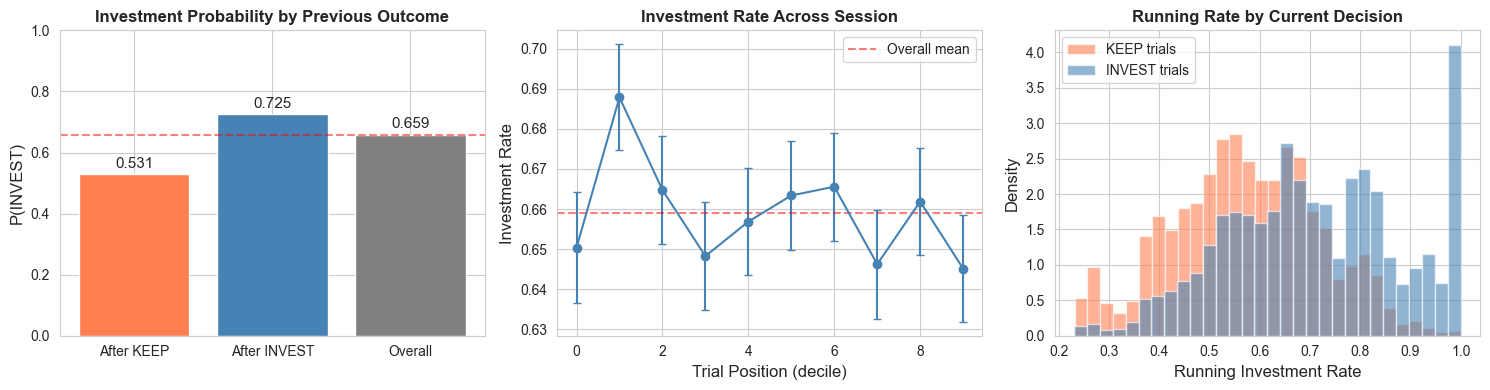

In [71]:
# Visualize transition probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Transition probabilities
ax1 = axes[0]
transitions = [
    ('After KEEP', p_invest_after_keep),
    ('After INVEST', p_invest_after_invest),
    ('Overall', df_valid['outcome'].mean())
]
labels, probs = zip(*transitions)
colors = ['coral', 'steelblue', 'gray']
bars = ax1.bar(labels, probs, color=colors)
ax1.axhline(y=df_valid['outcome'].mean(), color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel('P(INVEST)', fontsize=12)
ax1.set_title('Investment Probability by Previous Outcome', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
for bar, prob in zip(bars, probs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{prob:.3f}', ha='center', fontsize=11)

# 2. Investment rate by trial position
ax2 = axes[1]
df_valid['trial_bin'] = pd.cut(df_valid['trial_position'], bins=10, labels=False)
invest_by_position = df_valid.groupby('trial_bin')['outcome'].agg(['mean', 'sem', 'count'])
ax2.errorbar(invest_by_position.index, invest_by_position['mean'], 
             yerr=invest_by_position['sem'], marker='o', capsize=3, color='steelblue')
ax2.axhline(y=df_valid['outcome'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall mean')
ax2.set_xlabel('Trial Position (decile)', fontsize=12)
ax2.set_ylabel('Investment Rate', fontsize=12)
ax2.set_title('Investment Rate Across Session', fontsize=12, fontweight='bold')
ax2.legend()

# 3. Running investment rate distribution
ax3 = axes[2]
df_valid_late = df_valid[df_valid['trial_position'] > 0.2]  # After first 20% of trials
invest_group = df_valid_late[df_valid_late['outcome'] == 1]['running_invest_rate']
keep_group = df_valid_late[df_valid_late['outcome'] == 0]['running_invest_rate']
ax3.hist(keep_group, bins=30, alpha=0.6, label='KEEP trials', color='coral', density=True)
ax3.hist(invest_group, bins=30, alpha=0.6, label='INVEST trials', color='steelblue', density=True)
ax3.set_xlabel('Running Investment Rate', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Running Rate by Current Decision', fontsize=12, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

In [72]:
# Correlation of sequential features with outcome
print("\n" + "="*60)
print("CORRELATION WITH OUTCOME")
print("="*60)

correlations = []
for col in sequential_cols:
    valid_mask = df_valid[col].notna()
    if valid_mask.sum() > 100:
        corr, p = stats.pointbiserialr(df_valid.loc[valid_mask, col], 
                                        df_valid.loc[valid_mask, 'outcome'])
        correlations.append({'Feature': col, 'Correlation': corr, 'p-value': p})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)
print(corr_df.to_string(index=False))


CORRELATION WITH OUTCOME
             Feature  Correlation       p-value
 running_invest_rate     0.326393 5.441518e-306
recent_invest_rate_5     0.275306 9.498074e-215
        prev_outcome     0.194335 6.384743e-106
    consecutive_same     0.191679 4.799408e-103
      prev_outcome_2     0.162316  1.757808e-73
      trial_position    -0.009494  2.901595e-01


## 4. Prepare Data for Model Comparison

In [73]:
# Remove trials without valid sequential features (first trial of each subject)
df_model = merged_df[merged_df['prev_outcome'].notna()].copy()
print(f"Trials for modeling: {len(df_model)} (removed {len(merged_df) - len(df_model)} first trials)")

# Prepare feature matrices
# Physiology
X_physio_raw = df_model[physio_cols].values
X_physio_imputed = SimpleImputer(strategy='mean').fit_transform(X_physio_raw)
X_physio = StandardScaler().fit_transform(X_physio_imputed)

# Behavior
X_behavior_raw = df_model[behavior_cols].values
X_behavior_imputed = SimpleImputer(strategy='mean').fit_transform(X_behavior_raw)
X_behavior = StandardScaler().fit_transform(X_behavior_imputed)

# Gaze
if len(gaze_cols) > 0:
    X_gaze_raw = df_model[gaze_cols].values
    X_gaze_imputed = SimpleImputer(strategy='mean').fit_transform(X_gaze_raw)
    X_gaze = StandardScaler().fit_transform(X_gaze_imputed)
else:
    X_gaze = np.zeros((len(df_model), 1))

# Sequential features
X_sequential_raw = df_model[sequential_cols].values
X_sequential_imputed = SimpleImputer(strategy='mean').fit_transform(X_sequential_raw)
X_sequential = StandardScaler().fit_transform(X_sequential_imputed)

# Target and groups
y = df_model['outcome'].values
subjects = df_model['subject_id'].values

print(f"\nFeature shapes:")
print(f"  Physiology: {X_physio.shape}")
print(f"  Behavior: {X_behavior.shape}")
print(f"  Gaze: {X_gaze.shape}")
print(f"  Sequential: {X_sequential.shape}")

Trials for modeling: 12414 (removed 97 first trials)

Feature shapes:
  Physiology: (12414, 13)
  Behavior: (12414, 7)
  Gaze: (12414, 20)
  Sequential: (12414, 6)


## 5. Model Comparison Functions

In [74]:
def evaluate_single_modality(X, y, subjects, name, verbose=True):
    """Evaluate a single modality using LOSO CV."""
    logo = LeaveOneGroupOut()
    accs, f1s = [], []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    
    if verbose:
        print(f"{name}: Acc={np.mean(accs):.3f}±{stats.sem(accs):.3f}, F1={np.mean(f1s):.3f}")
    
    return {'name': name, 'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs),
            'f1': np.mean(f1s), 'subject_accs': accs}


def weighted_late_fusion(X_modalities, y, subjects, modality_names, verbose=True):
    """Weighted late fusion using logistic regression meta-learner."""
    logo = LeaveOneGroupOut()
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        # Inner CV for meta-learner training
        n_inner = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner < 2:
            n_inner = 2
        
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        gkf_inner = GroupKFold(n_splits=n_inner)
        
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        # Test predictions
        test_probs = []
        for X in X_modalities:
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            model.fit(X[train_idx], y_train)
            test_probs.append(model.predict_proba(X[test_idx])[:, 1])
        test_probs = np.column_stack(test_probs)
        
        # Meta-learner
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        y_pred = meta.predict(test_probs)
        
        test_subject = subjects[test_idx][0]
        subject_accs[test_subject] = accuracy_score(y_test, y_pred)
        subject_f1s[test_subject] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        all_weights.append(meta.coef_[0])
    
    acc_values = list(subject_accs.values())
    f1_values = list(subject_f1s.values())
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    if verbose:
        print(f"Fusion: Acc={np.mean(acc_values):.3f}±{stats.sem(acc_values):.3f}, F1={np.mean(f1_values):.3f}")
        print(f"  Weights: {dict(zip(modality_names, [f'{w:.3f}' for w in norm_weights]))}")
    
    return {
        'accuracy': np.mean(acc_values),
        'accuracy_sem': stats.sem(acc_values),
        'f1': np.mean(f1_values),
        'weights': dict(zip(modality_names, norm_weights)),
        'subject_accs': acc_values
    }

## 6. Evaluate Individual Modalities

In [75]:
print("\n" + "="*60)
print("INDIVIDUAL MODALITY PERFORMANCE")
print("="*60 + "\n")

results_physio = evaluate_single_modality(X_physio, y, subjects, "Physiology")
results_behavior = evaluate_single_modality(X_behavior, y, subjects, "Behavior")
results_gaze = evaluate_single_modality(X_gaze, y, subjects, "Gaze")
results_sequential = evaluate_single_modality(X_sequential, y, subjects, "Sequential")

print("\n--- Sequential Feature Breakdown ---")
# Test individual sequential features
for col in sequential_cols:
    col_idx = sequential_cols.index(col)
    X_single = X_sequential[:, col_idx:col_idx+1]
    evaluate_single_modality(X_single, y, subjects, f"  {col}", verbose=True)


INDIVIDUAL MODALITY PERFORMANCE

Physiology: Acc=0.535±0.014, F1=0.524
Behavior: Acc=0.646±0.013, F1=0.667
Gaze: Acc=0.501±0.016, F1=0.474
Sequential: Acc=0.615±0.019, F1=0.555

--- Sequential Feature Breakdown ---
  prev_outcome: Acc=0.622±0.017, F1=0.621
  prev_outcome_2: Acc=0.621±0.015, F1=0.621
  running_invest_rate: Acc=0.637±0.018, F1=0.557
  recent_invest_rate_5: Acc=0.593±0.017, F1=0.578
  trial_position: Acc=0.506±0.006, F1=0.539
  consecutive_same: Acc=0.495±0.017, F1=0.445


## 7. Compare Fusion Models

In [76]:
print("\n" + "="*60)
print("LATE FUSION MODEL COMPARISON")
print("="*60)

# Baseline: Original 3-modality fusion (Physio + Behavior + Gaze)
print("\n--- Baseline: Physio + Behavior + Gaze ---")
X_baseline = [X_physio, X_behavior, X_gaze]
names_baseline = ['Physio', 'Behavior', 'Gaze']
results_baseline = weighted_late_fusion(X_baseline, y, subjects, names_baseline)

# With Sequential: 4-modality fusion
print("\n--- With Sequential: Physio + Behavior + Gaze + Sequential ---")
X_with_seq = [X_physio, X_behavior, X_gaze, X_sequential]
names_with_seq = ['Physio', 'Behavior', 'Gaze', 'Sequential']
results_with_seq = weighted_late_fusion(X_with_seq, y, subjects, names_with_seq)

# Behavior + Sequential only (since behavior is most predictive)
print("\n--- Behavior + Sequential Only ---")
X_behav_seq = [X_behavior, X_sequential]
names_behav_seq = ['Behavior', 'Sequential']
results_behav_seq = weighted_late_fusion(X_behav_seq, y, subjects, names_behav_seq)

# Sequential only
print("\n--- Sequential Only ---")
results_seq_only = evaluate_single_modality(X_sequential, y, subjects, "Sequential Only")


LATE FUSION MODEL COMPARISON

--- Baseline: Physio + Behavior + Gaze ---
Fusion: Acc=0.683±0.015, F1=0.660
  Weights: {'Physio': '0.100', 'Behavior': '0.894', 'Gaze': '0.006'}

--- With Sequential: Physio + Behavior + Gaze + Sequential ---
Fusion: Acc=0.719±0.014, F1=0.698
  Weights: {'Physio': '0.013', 'Behavior': '0.390', 'Gaze': '0.002', 'Sequential': '0.595'}

--- Behavior + Sequential Only ---
Fusion: Acc=0.719±0.015, F1=0.699
  Weights: {'Behavior': '0.397', 'Sequential': '0.603'}

--- Sequential Only ---
Sequential Only: Acc=0.615±0.019, F1=0.555


In [77]:
# Summary comparison
print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)

comparison = pd.DataFrame([
    {'Model': 'Baseline (P+B+G)', 'Accuracy': results_baseline['accuracy'], 
     'SEM': results_baseline['accuracy_sem'], 'F1': results_baseline['f1']},
    {'Model': 'With Sequential (P+B+G+S)', 'Accuracy': results_with_seq['accuracy'],
     'SEM': results_with_seq['accuracy_sem'], 'F1': results_with_seq['f1']},
    {'Model': 'Behavior + Sequential', 'Accuracy': results_behav_seq['accuracy'],
     'SEM': results_behav_seq['accuracy_sem'], 'F1': results_behav_seq['f1']},
    {'Model': 'Sequential Only', 'Accuracy': results_seq_only['accuracy'],
     'SEM': results_seq_only['accuracy_sem'], 'F1': results_seq_only['f1']},
])

comparison['Improvement'] = comparison['Accuracy'] - results_baseline['accuracy']
print(comparison.to_string(index=False))

# Statistical test: baseline vs with sequential
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(results_baseline['subject_accs'], results_with_seq['subject_accs'])
print(f"\nPaired t-test (Baseline vs With Sequential): t={t_stat:.3f}, p={p_val:.4f}")


SUMMARY COMPARISON
                    Model  Accuracy      SEM       F1  Improvement
         Baseline (P+B+G)  0.682672 0.015362 0.660326     0.000000
With Sequential (P+B+G+S)  0.718961 0.014456 0.697944     0.036289
    Behavior + Sequential  0.718862 0.014514 0.698656     0.036189
          Sequential Only  0.614553 0.019074 0.555492    -0.068119

Paired t-test (Baseline vs With Sequential): t=-4.008, p=0.0001


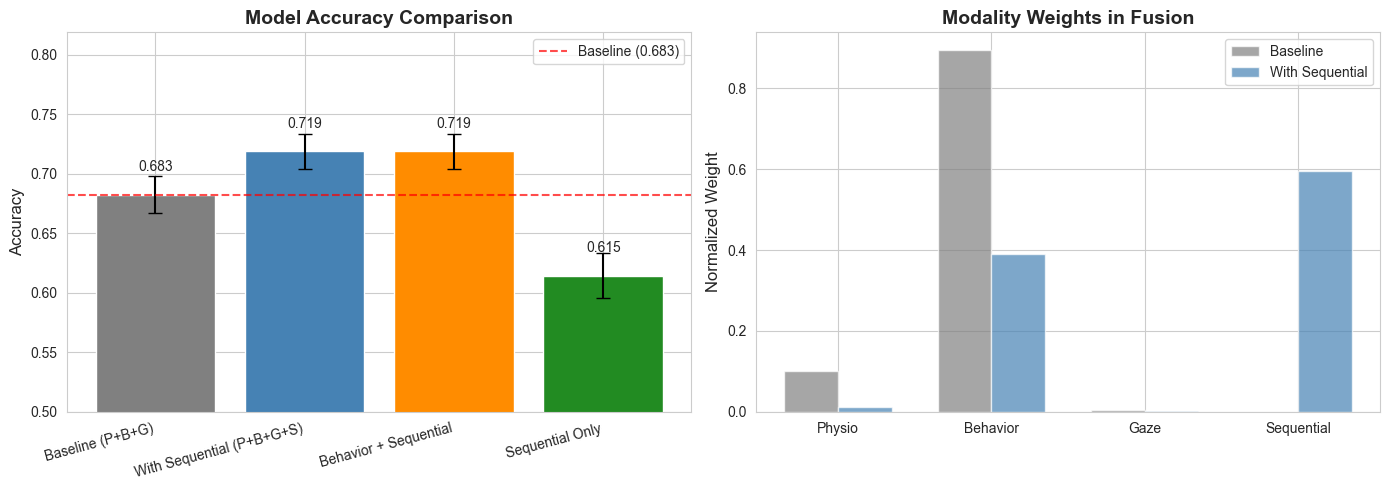

In [78]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Model comparison
ax1 = axes[0]
colors = ['gray', 'steelblue', 'darkorange', 'forestgreen']
bars = ax1.bar(comparison['Model'], comparison['Accuracy'], 
               yerr=comparison['SEM'], capsize=5, color=colors)
ax1.axhline(y=results_baseline['accuracy'], color='red', linestyle='--', 
            alpha=0.7, label=f"Baseline ({results_baseline['accuracy']:.3f})")
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, max(comparison['Accuracy']) + 0.1)
ax1.legend()
ax1.set_xticklabels(comparison['Model'], rotation=15, ha='right')

# Add accuracy labels
for bar, acc in zip(bars, comparison['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{acc:.3f}', ha='center', fontsize=10)

# 2. Modality weights comparison
ax2 = axes[1]
weight_data = {
    'Baseline': results_baseline['weights'],
    'With Sequential': results_with_seq['weights']
}

x = np.arange(len(names_with_seq))
width = 0.35

baseline_weights = [results_baseline['weights'].get(n, 0) for n in names_with_seq]
with_seq_weights = [results_with_seq['weights'].get(n, 0) for n in names_with_seq]

ax2.bar(x - width/2, baseline_weights, width, label='Baseline', color='gray', alpha=0.7)
ax2.bar(x + width/2, with_seq_weights, width, label='With Sequential', color='steelblue', alpha=0.7)

ax2.set_ylabel('Normalized Weight', fontsize=12)
ax2.set_title('Modality Weights in Fusion', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(names_with_seq)
ax2.legend()

plt.tight_layout()
plt.show()

## 8. Analyze Effect by Trial Position

In [79]:
# Does the predictive power of sequential features change across the session?
print("\n" + "="*60)
print("PREDICTIVE POWER BY TRIAL POSITION")
print("="*60)

# Split trials into early (first third) vs late (last third)
df_model['position_bin'] = pd.cut(df_model['trial_position'], 
                                   bins=[0, 0.33, 0.67, 1.0], 
                                   labels=['Early', 'Middle', 'Late'])

results_by_position = []

for position in ['Early', 'Middle', 'Late']:
    mask = df_model['position_bin'] == position
    df_pos = df_model[mask]
    
    if len(df_pos) < 100:
        continue
    
    # Get indices in the original arrays
    pos_indices = df_model[mask].index.tolist()
    pos_idx_array = np.array([df_model.index.get_loc(i) for i in pos_indices])
    
    X_seq_pos = X_sequential[pos_idx_array]
    y_pos = y[pos_idx_array]
    subjects_pos = subjects[pos_idx_array]
    
    # Simple accuracy (no LOSO for speed)
    from sklearn.model_selection import cross_val_score
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    scores = cross_val_score(model, X_seq_pos, y_pos, cv=5, scoring='accuracy')
    
    results_by_position.append({
        'Position': position,
        'N_trials': len(df_pos),
        'Invest_rate': df_pos['outcome'].mean(),
        'Sequential_acc': np.mean(scores),
        'Sequential_std': np.std(scores)
    })
    
    print(f"{position}: n={len(df_pos)}, invest_rate={df_pos['outcome'].mean():.3f}, "
          f"seq_acc={np.mean(scores):.3f}±{np.std(scores):.3f}")

pos_df = pd.DataFrame(results_by_position)
print("\n" + pos_df.to_string(index=False))


PREDICTIVE POWER BY TRIAL POSITION
Early: n=3997, invest_rate=0.668, seq_acc=0.567±0.068
Middle: n=4241, invest_rate=0.657, seq_acc=0.627±0.062
Late: n=4166, invest_rate=0.652, seq_acc=0.637±0.049

Position  N_trials  Invest_rate  Sequential_acc  Sequential_std
   Early      3997     0.668001        0.566965        0.068289
  Middle      4241     0.657156        0.626999        0.061969
    Late      4166     0.651704        0.636840        0.049031


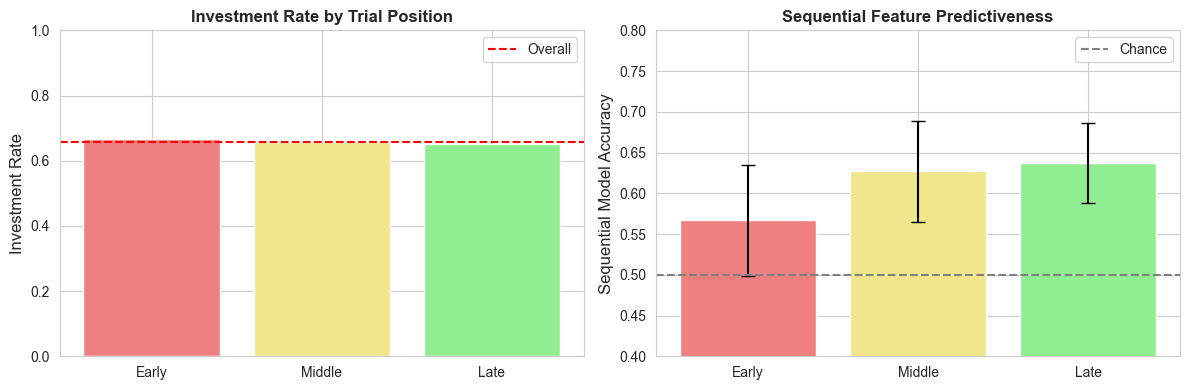

In [80]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Investment rate by position
ax1 = axes[0]
colors = ['lightcoral', 'khaki', 'lightgreen']
bars = ax1.bar(pos_df['Position'], pos_df['Invest_rate'], color=colors)
ax1.axhline(y=df_model['outcome'].mean(), color='red', linestyle='--', label='Overall')
ax1.set_ylabel('Investment Rate', fontsize=12)
ax1.set_title('Investment Rate by Trial Position', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.legend()

# Sequential prediction accuracy by position
ax2 = axes[1]
bars = ax2.bar(pos_df['Position'], pos_df['Sequential_acc'], 
               yerr=pos_df['Sequential_std'], capsize=5, color=colors)
ax2.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
ax2.set_ylabel('Sequential Model Accuracy', fontsize=12)
ax2.set_title('Sequential Feature Predictiveness', fontsize=12, fontweight='bold')
ax2.set_ylim(0.4, 0.8)
ax2.legend()

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

In [81]:
# Train a model on all data to examine feature importance
from sklearn.inspection import permutation_importance

# Combine ALL modalities (Physiology + Behavior + Gaze + Sequential)
X_combined = np.hstack([X_physio, X_behavior, X_gaze, X_sequential])
combined_cols = physio_cols + behavior_cols + gaze_cols + sequential_cols
modality_labels = (['Physiology'] * len(physio_cols) + 
                   ['Behavior'] * len(behavior_cols) + 
                   ['Gaze'] * len(gaze_cols) + 
                   ['Sequential'] * len(sequential_cols))

# Train model
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_combined, y)

# Get coefficients
importance_df = pd.DataFrame({
    'Feature': combined_cols,
    'Coefficient': np.abs(model.coef_[0]),
    'Type': modality_labels
}).sort_values('Coefficient', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (All Modalities)")
print("="*60)
print(f"\nTop 20 features:")
print(importance_df.head(20).to_string(index=False))

print(f"\n--- By Modality (sum of absolute coefficients) ---")
modality_importance = importance_df.groupby('Type')['Coefficient'].sum().sort_values(ascending=False)
print(modality_importance.to_string())


FEATURE IMPORTANCE (All Modalities)

Top 20 features:
               Feature  Coefficient       Type
      consecutive_same     0.771509 Sequential
             ambiguity     0.753100   Behavior
   running_invest_rate     0.622347 Sequential
         reaction_time     0.332737   Behavior
gaze_acceleration_mean     0.233636       Gaze
          risk_premium     0.231267   Behavior
       invest_variance     0.197648   Behavior
         saccade_ratio     0.183303       Gaze
    gaze_velocity_mean     0.181386       Gaze
     gaze_dispersion_x     0.151819       Gaze
         pupil_std_pre     0.145642 Physiology
         saccade_count     0.134293       Gaze
         ev_difference     0.129921   Behavior
 pct_time_dilating_pre     0.119324 Physiology
          screen_y_std     0.116388       Gaze
       pupil_slope_pre     0.115390 Physiology
        trial_position     0.110567 Sequential
            gaze_y_std     0.105582       Gaze
         decision_time     0.104800   Behavior
     

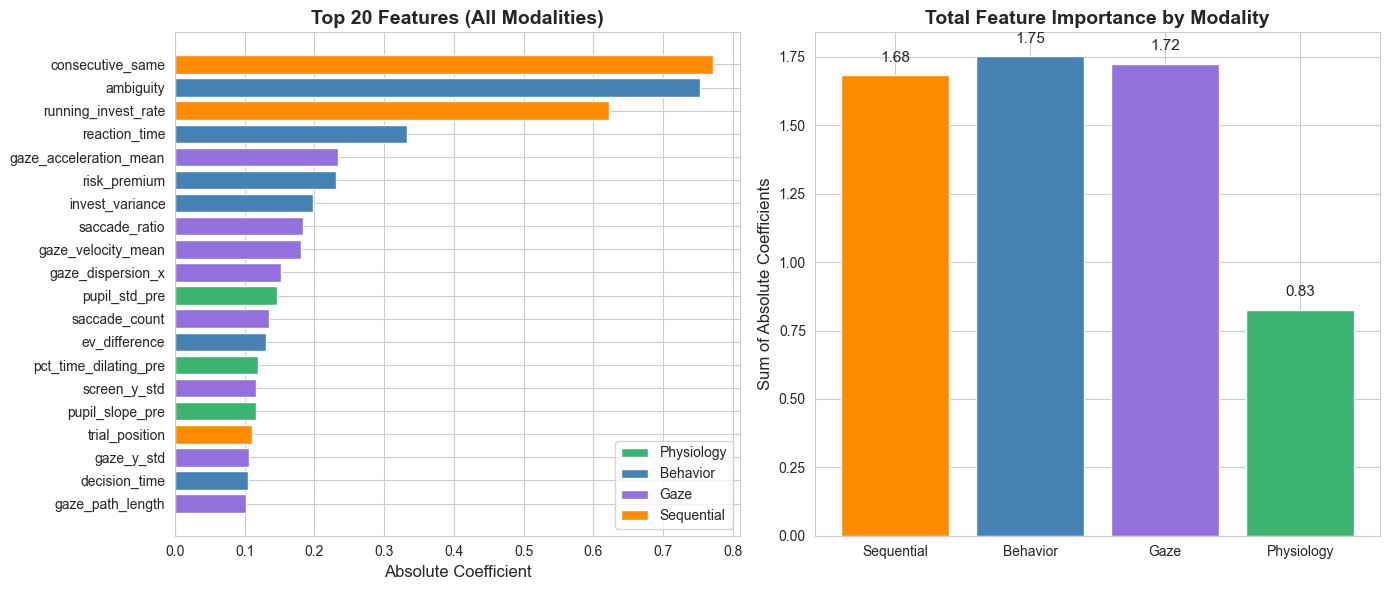

In [82]:
# Visualize feature importance (top 20 features from all modalities)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color mapping for modalities
color_map = {
    'Physiology': 'mediumseagreen',
    'Behavior': 'steelblue', 
    'Gaze': 'mediumpurple',
    'Sequential': 'darkorange'
}

# 1. Top 20 features
ax1 = axes[0]
top20 = importance_df.head(20)
colors = [color_map[t] for t in top20['Type']]
bars = ax1.barh(top20['Feature'], top20['Coefficient'], color=colors)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=m) for m, c in color_map.items()]
ax1.legend(handles=legend_elements, loc='lower right')

ax1.set_xlabel('Absolute Coefficient', fontsize=12)
ax1.set_title('Top 20 Features (All Modalities)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# 2. Total importance by modality
ax2 = axes[1]
modality_order = ['Sequential', 'Behavior', 'Gaze', 'Physiology']
modality_totals = [modality_importance.get(m, 0) for m in modality_order]
modality_colors = [color_map[m] for m in modality_order]

bars = ax2.bar(modality_order, modality_totals, color=modality_colors)
ax2.set_ylabel('Sum of Absolute Coefficients', fontsize=12)
ax2.set_title('Total Feature Importance by Modality', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, modality_totals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{val:.2f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 10. Save Results

In [83]:
import os

output_dir = f'../../data/results/previous_trial_effects_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# Save model comparison
save_results(comparison, f'{output_dir}/model_comparison_{TIMEFRAME}.csv')

# Save feature importance
save_results(importance_df, f'{output_dir}/feature_importance_{TIMEFRAME}.csv')

# Save correlation analysis
save_results(corr_df, f'{output_dir}/sequential_correlations_{TIMEFRAME}.csv')

# Save position analysis
save_results(pos_df, f'{output_dir}/position_analysis_{TIMEFRAME}.csv')

print(f"\n✓ Results saved to: {output_dir}/")

✓ Saved results to: ../../data/results/previous_trial_effects_PRE/model_comparison_PRE.csv
✓ Saved results to: ../../data/results/previous_trial_effects_PRE/feature_importance_PRE.csv
✓ Saved results to: ../../data/results/previous_trial_effects_PRE/sequential_correlations_PRE.csv
✓ Saved results to: ../../data/results/previous_trial_effects_PRE/position_analysis_PRE.csv

✓ Results saved to: ../../data/results/previous_trial_effects_PRE/


## 11. Summary and Conclusions

In [84]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS ({TIMEFRAME})")
print("="*70)

print(f"\n1. TRANSITION PROBABILITIES:")
print(f"   P(INVEST | prev=INVEST) = {p_invest_after_invest:.3f}")
print(f"   P(INVEST | prev=KEEP)   = {p_invest_after_keep:.3f}")
print(f"   → Participants are {p_invest_after_invest - p_invest_after_keep:.1%} more likely to INVEST after INVEST")

print(f"\n2. SEQUENTIAL FEATURES ALONE:")
print(f"   Accuracy: {results_seq_only['accuracy']:.3f}")
print(f"   → Previous trial info alone predicts {results_seq_only['accuracy']:.1%} of decisions")

print(f"\n3. FUSION MODEL IMPROVEMENT:")
print(f"   Baseline (P+B+G):      {results_baseline['accuracy']:.3f}")
print(f"   With Sequential:       {results_with_seq['accuracy']:.3f}")
improvement = results_with_seq['accuracy'] - results_baseline['accuracy']
print(f"   Improvement:           {improvement:+.3f} ({improvement*100:+.1f}%)")

print(f"\n4. MODALITY WEIGHTS (With Sequential):")
for name, weight in results_with_seq['weights'].items():
    print(f"   {name}: {weight:.1%}")

print(f"\n5. CONCLUSION:")
if improvement > 0.01:
    print(f"   ✓ Adding sequential features IMPROVES prediction")
    print(f"   ✓ Previous trial outcome is informative for current decisions")
    print(f"   ✓ Suggests participants learn/adapt during the task")
elif improvement > -0.01:
    print(f"   ~ Sequential features have MINIMAL impact on fusion accuracy")
    print(f"   ~ But individual sequential model shows trials are autocorrelated")
else:
    print(f"   ✗ Sequential features DECREASE fusion accuracy")
    print(f"   ✗ May be redundant with behavioral features")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS (PRE)

1. TRANSITION PROBABILITIES:
   P(INVEST | prev=INVEST) = 0.725
   P(INVEST | prev=KEEP)   = 0.531
   → Participants are 19.4% more likely to INVEST after INVEST

2. SEQUENTIAL FEATURES ALONE:
   Accuracy: 0.615
   → Previous trial info alone predicts 61.5% of decisions

3. FUSION MODEL IMPROVEMENT:
   Baseline (P+B+G):      0.683
   With Sequential:       0.719
   Improvement:           +0.036 (+3.6%)

4. MODALITY WEIGHTS (With Sequential):
   Physio: 1.3%
   Behavior: 39.0%
   Gaze: 0.2%
   Sequential: 59.5%

5. CONCLUSION:
   ✓ Adding sequential features IMPROVES prediction
   ✓ Previous trial outcome is informative for current decisions
   ✓ Suggests participants learn/adapt during the task

